<br>
<h1 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">SETI - Signal Search <br>  EDA & Baseline Model </h1>
<br>

## <a name="Wheat Detection">SETI - Signal Search </a>

#### <a name="About_Competition"> Introduction </a>

In this competition, use your data science skills to help identify anomalous signals in scans of Breakthrough Listen targets. Because there are no confirmed examples of alien signals to use to train machine learning algorithms, the team included some simulated signals (that they call “needles”) in the haystack of data from the telescope. They have identified some of the hidden needles so that you can train your model to find more. The data consist of two-dimensional arrays, so there may be approaches from computer vision that are promising, as well as digital signal processing, anomaly detection, and more. The algorithm that’s successful at identifying the most needles will win a cash prize, but also has the potential to help answer one of the biggest questions in science.



#### <a name="Specific Objectives">Specific Objectives</a>           

The main objective of the competition is to develop machine learning-based models to accurately classify anomalous signals in scans of Breakthrough Listen targets.


#### <a name="dataset_description">Dataset Description</a>: 

In this competition you are tasked with looking for technosignature signals in cadence snippets taken from the Green Bank Telescope (GBT). Please read the extended description on the Data Information tab for detailed information about the data (that's too lengthy to include here).

#### Files - 
##### train/ -
  Training set of cadence snippet files stored in numpy float16 format (v1.20.1), one file per cadence snippet id, with corresponding labels found in the train_labels.csv file. 
  
 Each file has dimension (6, 273, 256)
 
*  1st dimension representing the 6 positions of the cadence
*  2nd and 3rd dimensions representing the 2D spectrogram.
 
 
##### test/ - 
the test set cadence snippet files; you must predict whether or not the cadence contains a "needle", which is the target for this competition

sample_submission.csv - a sample submission file in the correct format
train_labels - targets corresponding (by id) to the cadence snippet files found in the train/ folder


  1. cadence snippet id of file 
  2. target - 1 or 0
    

#### <a name="target_variable">Target Variable</a>                                        
* __Submission data__  
    1. cadence snippet id of file 
    2. target - 1 or 0

Catagory of Labels :- 



# Contents

* [<font size=4>EDA</font>](#1)
    * [Preparing the ground](#1.1)


* [<font size=4>Image processing </font>](#2)
    * [Visualise the data](#2.1)


In [1]:
import pandas as pd
import numpy as np
import os

# Data Visualisation libraries 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

## Image Augmentation 

# skimage
from skimage.io import imshow, imread, imsave
from skimage.transform import rotate, AffineTransform, warp,rescale, resize, downscale_local_mean
from skimage import color,data
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [2]:
from tqdm import tqdm

In [3]:
PATH = '../input/seti-breakthrough-listen/'

In [4]:
df_train = pd.read_csv(PATH+'train_labels.csv')

In [5]:
df_train.head()

,id,target
0,00034abb3629,0
1,0004300a0b9b,0
2,000453852fda,0
3,00047dfc96a9,0
4,0004be0baf70,0


In [6]:
df_train.target.value_counts()

0    45471
1     4694
Name: target, dtype: int64

In [7]:
source = df_train['target'].value_counts()
fig = go.Figure(data=[go.Pie(labels=source.index,values=source.values)])
fig.update_layout(title='Target distribution')
fig.show()


## Observation 

- Dataset is pretty unbalanced as per above pie chart 
- Need to chose the appropirate sampling strategy while modeling 

In [8]:
def get_train_filename_by_id(_id: str) -> str:
    return f"{PATH}/train/{_id[0]}/{_id}.npy"

In [9]:
get_train_filename_by_id(df_train.iloc[0]["id"])

'../input/seti-breakthrough-listen//train/0/00034abb3629.npy'

# Lets find out Shape of training data

In [10]:
tmp_filename = get_train_filename_by_id(df_train.iloc[0]["id"])
tr_data = np.load(tmp_filename)
tr_data.shape

(6, 273, 256)

# Visualise the training data

## Referance :- 

 Data plot Code taken from below kernal  

[link](https://www.kaggle.com/ihelon/signal-search-exploratory-data-analysis)

In [11]:
def show_cadence(filename: str, label: int) -> None:
    plt.figure(figsize=(16, 10))
    arr = np.load(filename)
    for i in range(6):
        plt.subplot(6, 1, i + 1)
        if i == 0:
            plt.title(f"ID: {os.path.basename(filename)} TARGET: {label}", fontsize=18)
        plt.imshow(arr[i].astype(float), interpolation='nearest', aspect='auto')
        plt.text(5, 100, ["ON", "OFF"][i % 2], bbox={'facecolor': 'white'})
        plt.xticks([])
    plt.show()

In [12]:
def display_cadance(df,num_sample:int,target:int) -> None:
    for i in range(1,num_sample):
        show_cadence(get_train_filename_by_id(df_train[df_train["target"] == target]['id'][i]),df_train[df_train["target"] == target]['target'][i])

In [13]:
def display_cadance(df,num_sample:int,target:int) -> None:
    df = df[df['target']==target].sample(num_sample)
    for idx,row in df.iterrows():
        show_cadence(get_train_filename_by_id(row["id"]),row["target"])

<br>
<h1 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">SETI - Signal Search <br>  Getting Sense of Cadence data </h1>
<br>

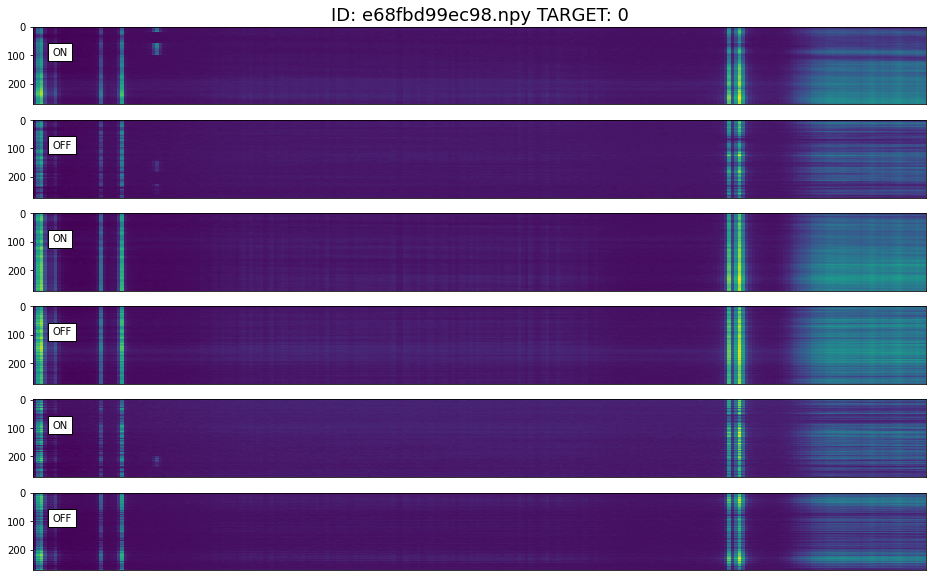

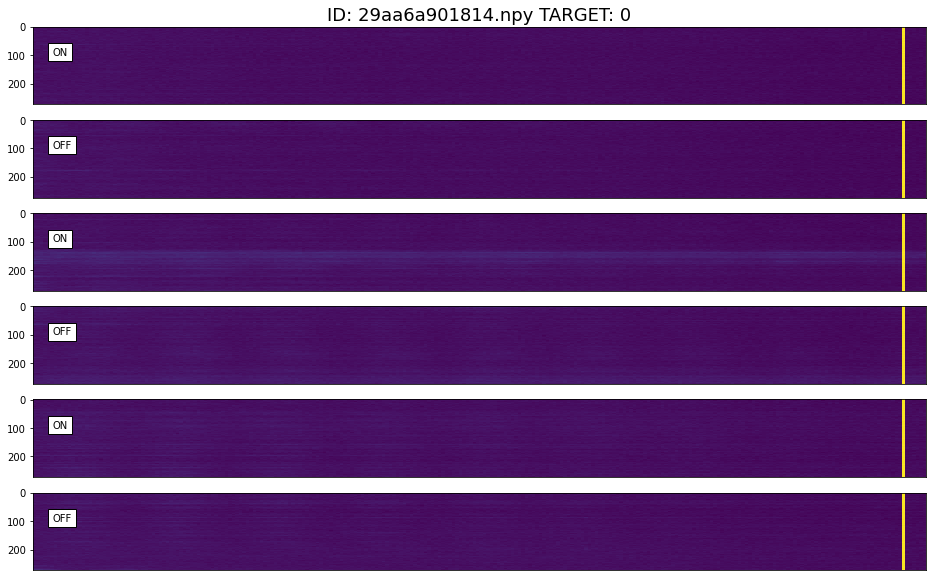

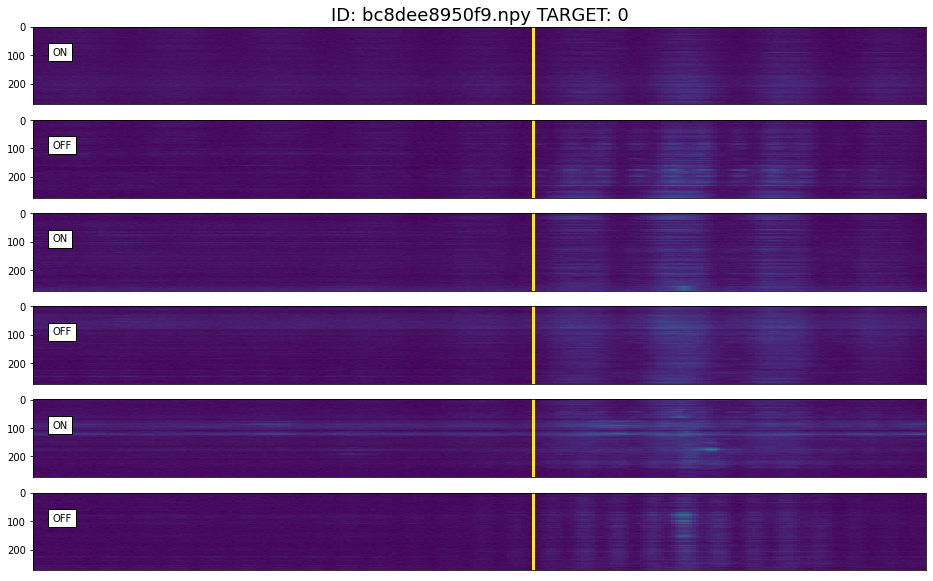

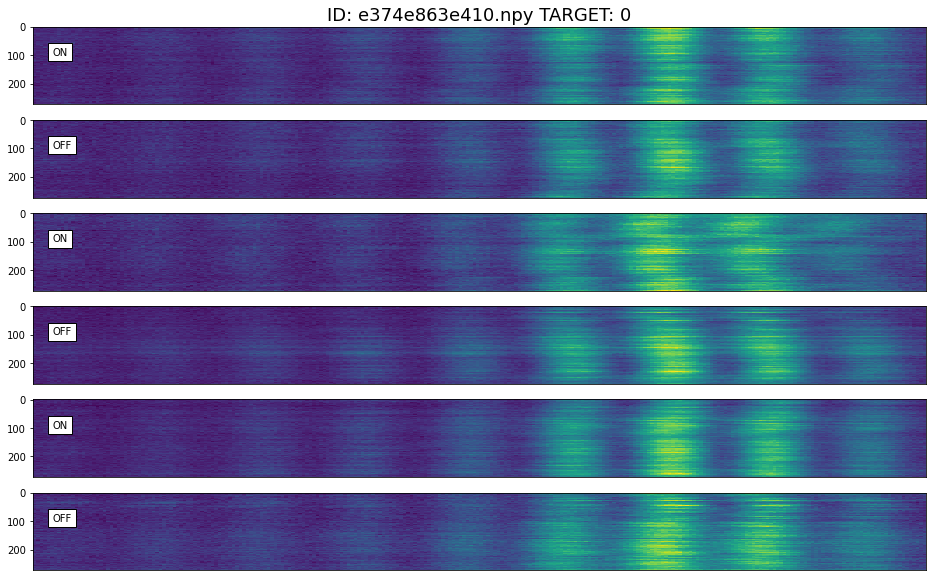

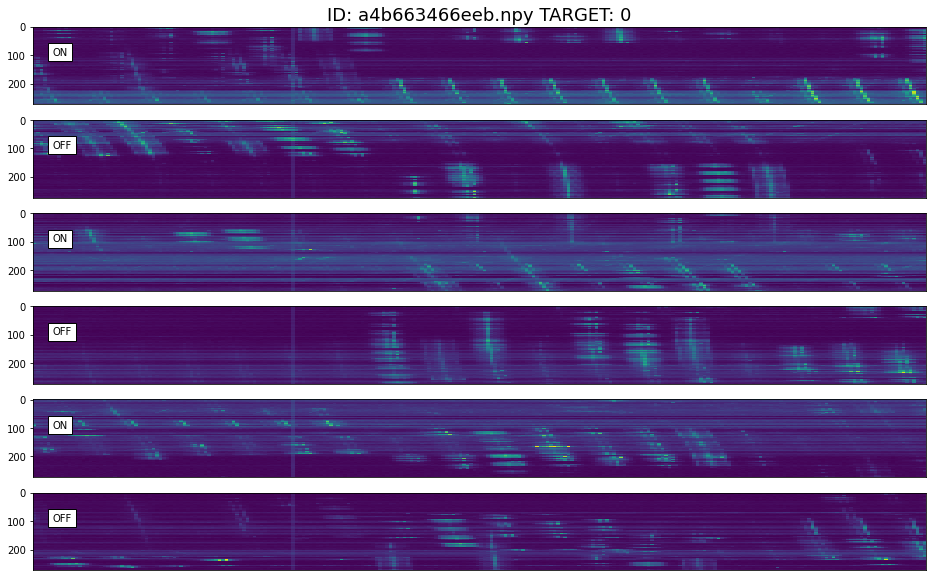

In [14]:
display_cadance(df_train,num_sample=5,target=0)

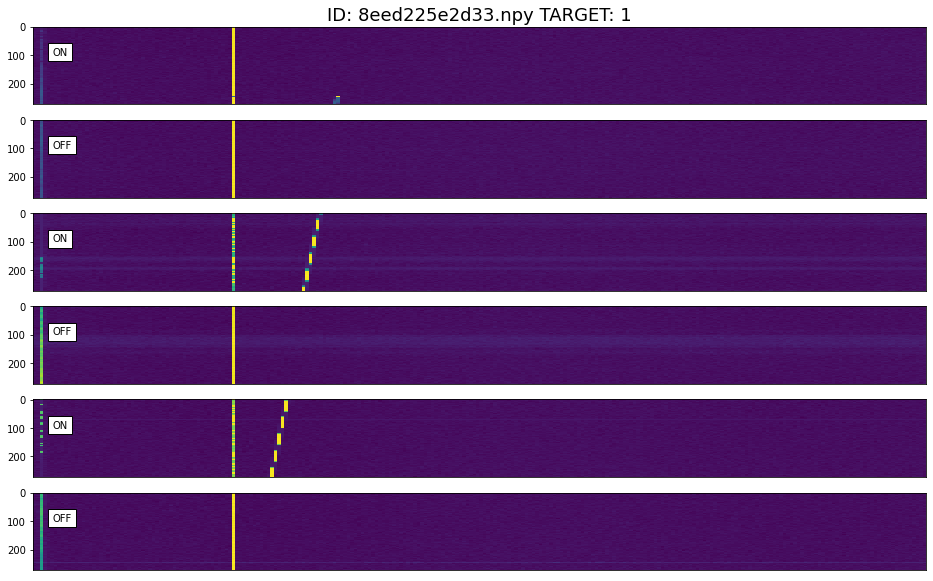

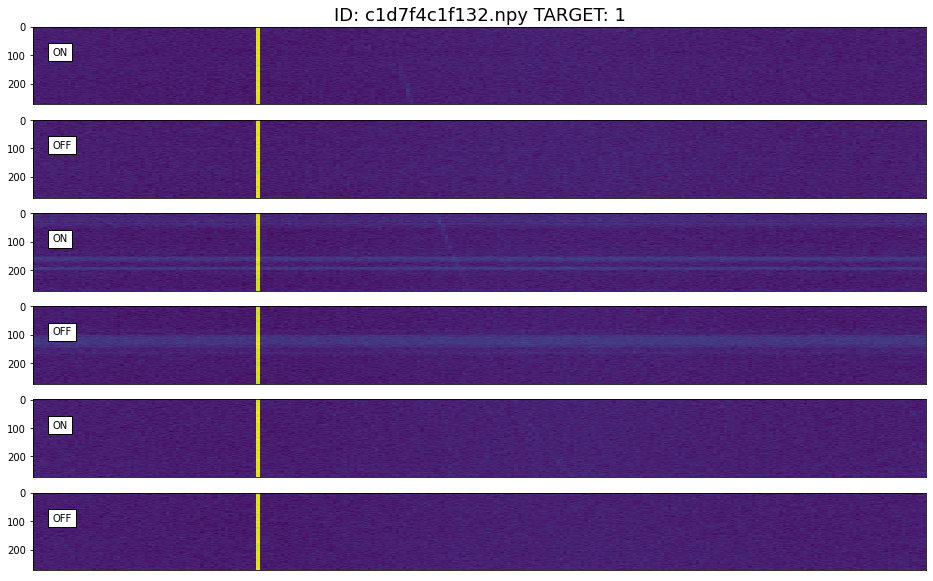

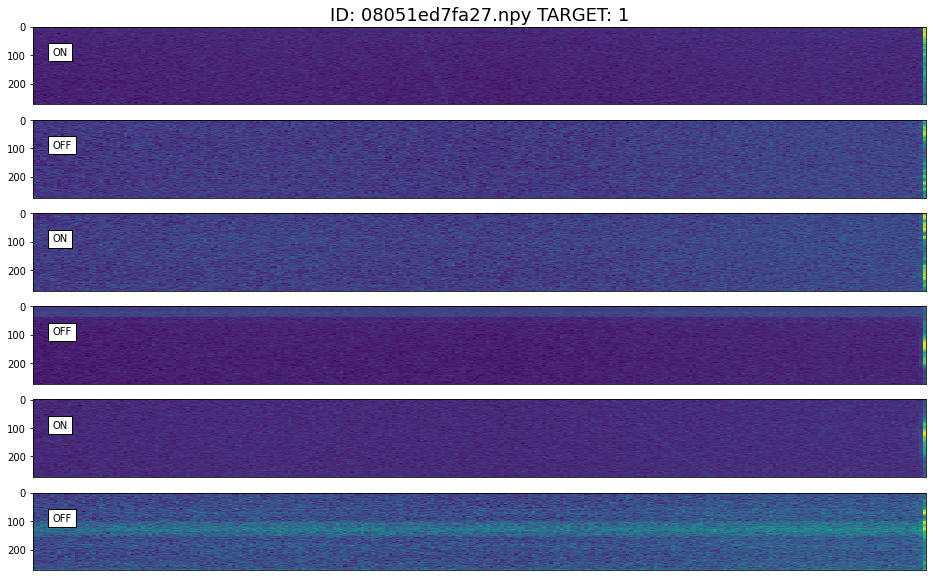

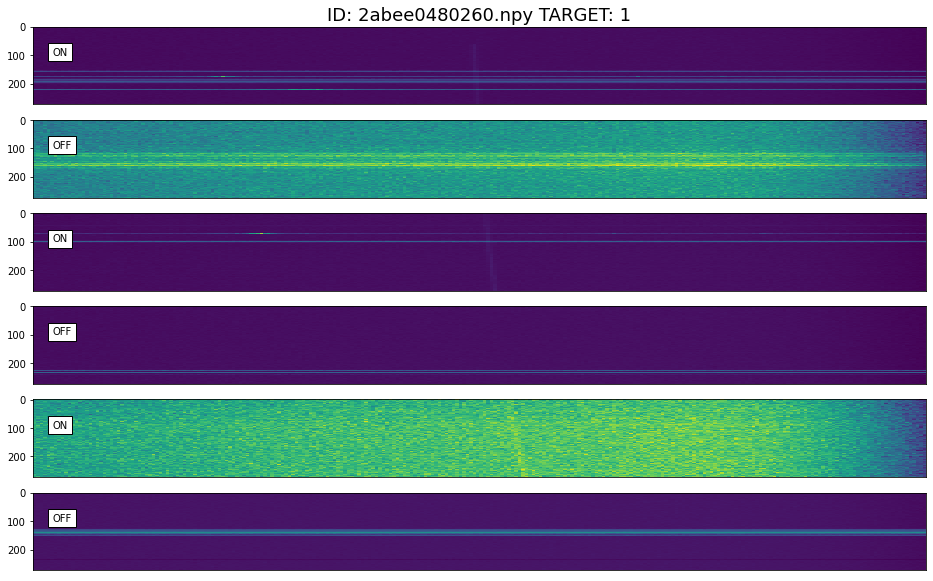

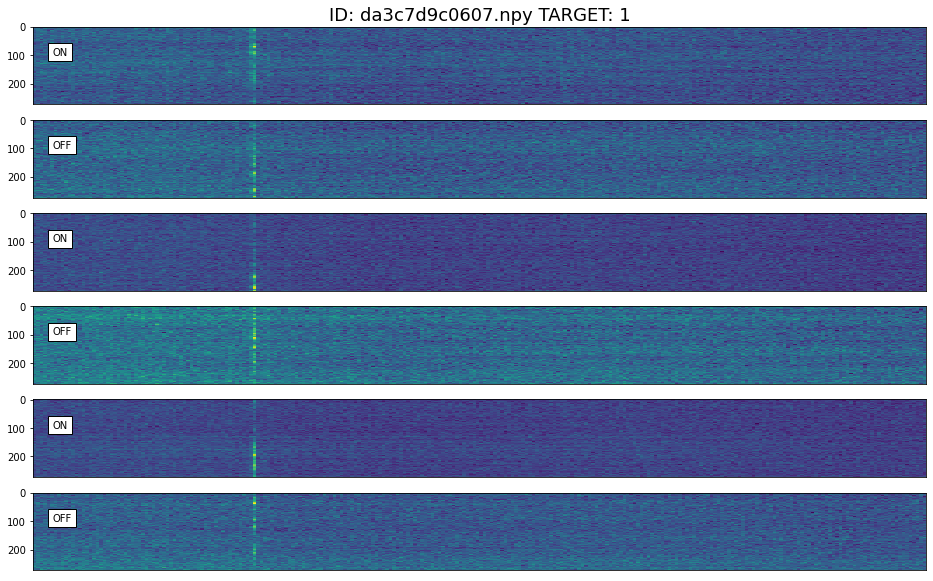

In [15]:
display_cadance(df_train,num_sample=5,target=1)

### Lets kick start modeling

#####  Refence for below model , Kindly upvote below kernal

[link](https://www.kaggle.com/jiny333/pytorch-simple-baseline-resnet-18-trn-infer)

In [16]:
!pip install -q pretrainedmodels

In [17]:
import glob
import cv2
from sklearn.model_selection import train_test_split
import sklearn.metrics
import albumentations

import torch

In [18]:
df_train

,id,target
0,00034abb3629,0
1,0004300a0b9b,0
2,000453852fda,0
3,00047dfc96a9,0
4,0004be0baf70,0
...,...,...
50160,fff395e32a1e,0
50161,fff66bbc51db,0
50162,fffaf1658eb7,0
50163,fffb0fc8c613,0


In [19]:
import torch

class ClassificationDataset:
    
    def __init__(self, image_paths, targets, resize=None, augmentations=None): 
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):      
        image = np.load(self.image_paths[item]).astype(float)

        targets = self.targets[item]
        
        if self.resize is not None:
            image = np.transpose(image, (1,2,0))
            image = cv2.resize(image, dsize=self.resize, interpolation=cv2.INTER_CUBIC)        
        
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
            
        # pytorch expects CHW instead of HWC
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            "image": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [20]:
df_train['img_pth'] = df_train['id'].apply(lambda x:f'{PATH}/train/{x[0]}/{x}.npy')

# Preparing data for Training & Validation

In [21]:
def data_prep(img_paths,tgts,dataclass):
    
    images = img_paths.values
    targets = tgts.values
    train_images, valid_images, train_targets, valid_targets = train_test_split(images, targets, stratify=targets, random_state=42)

    train_dataset = dataclass(train_images,train_targets,resize=(224,224))
    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True,num_workers=4)

    valid_dataset = dataclass(valid_images,valid_targets,resize=(224,224))
    valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=16,shuffle=False,num_workers=4)
    
    return train_loader,valid_loader

In [22]:
train_loader,valid_loader = data_prep(df_train['img_pth'],df_train["target"],ClassificationDataset)

In [23]:
def train(data_loader, model, optimizer, device):
    
    model.train()
    
    for data in tqdm(data_loader, position=0, leave=True, desc='Training'):
        inputs = data["image"]
        targets = data['targets']
        
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()
        
def evaluate(data_loader, model, device):
    model.eval()
    
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        
        for data in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            
            output = model(inputs)
            
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets

In [24]:
import torch.nn as nn
import pretrainedmodels

def get_model(pretrained):
    if pretrained:
        model = pretrainedmodels.__dict__["resnet18"](pretrained='imagenet')
    else:
        model = pretrainedmodels.__dict__["resnet18"](pretrained=None)
        
    model.last_linear = nn.Sequential(
        nn.BatchNorm1d(512),
        nn.Dropout(p=0.25),
        nn.Linear(in_features=512, out_features=1024),
        nn.ReLU(),
        nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=1024, out_features=1)
    )
    
    return model

In [25]:
device = "cuda"
epochs = 5

model = get_model(pretrained=False)
model.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3,bias=False)
model.to(device)
aug = None
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [26]:
for epoch in range(epochs):
    train(train_loader, model, optimizer, device=device)
    predictions, valid_targets = evaluate(valid_loader, model, device=device)
    roc_auc = sklearn.metrics.roc_auc_score(valid_targets, predictions)
    print(f"Epoch={epoch}, Valid ROC AUC={roc_auc}")

Training:   0%|          | 0/2352 [00:00<?, ?it/s]

Epoch=0, Valid ROC AUC=0.5447625181776876


Training:   0%|          | 0/2352 [00:00<?, ?it/s]

Epoch=1, Valid ROC AUC=0.5377296038253168


Training:   0%|          | 0/2352 [00:00<?, ?it/s]

Epoch=2, Valid ROC AUC=0.5752614335107243


Training:   0%|          | 0/2352 [00:00<?, ?it/s]

Epoch=3, Valid ROC AUC=0.5889411549440313


Evaluating: 100%|██████████| 784/784 [01:40<00:00,  7.83it/s]

Epoch=4, Valid ROC AUC=0.58076378057538


## ...working to add another model in this kernal for ROC-AUC comparison 

# Kindly Upvote if you like this kernal